ok同步成功
本实验基于networkx和DeepSNAP库进行图数据的操作。DeepSNAP是一个Python库，可帮助在图形上进行高效的深度学习。DeepSNAP 支持灵活的图形操作，标准管道，异构图形和简单的 API。
  本实验完成了一个可泛化的 GNN 堆叠模型，可以通过调整参数：model 来选择不同的GNN 层（包括 torch_geometric.nn 包中已集成的 GCN、GAT、GraphSage 层，以及我们在第七章中自定义的ourGNNLayer 层）。



In [6]:
import torch
print(torch.__version__)



1.13.0.dev20220920


AttributeError: module 'torch.version' has no attribute 'mps'

In [4]:
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from torch.nn import Linear
from torch.utils.data import DataLoader

from torch_geometric.nn.conv import MessagePass_ing

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset

ModuleNotFoundError: No module named 'torch_sparse'

1. 数据介绍
实验以 [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html?highlight=Planetoid#torch_geometric.datasets.Planetoid) 数据集中的 Cora 引文数据网络[1]为例进行节点分类任务。
* Cora 是一个根据科学论文之间相互引用关系而构建的图数据集，其中包含了共 2708 篇科学出版物，即对应了图中的 2708 个节点，此外图中共有5429条连边。出版物根据其内容被分为7类（即节点的标签有7类），包括遗传算法、神经网络、强化学习等七个领域。
* 连边表示文章间的引用关系，每篇文章都至少引用了一篇其它文章，或者被其它文章引用，没有任何一篇文章与其它文章完全没有联系。如果将文章视作图中的节点，则 Cora 数据集对应的是连通图。
* 每篇文章都由一个1433维的词向量表示，因而图中每个样本点具有1433维特征。词向量的每个元素都对应一个具体单词，其有0和1两种取值，0表示该元素对应的词不在文章中，1则表示被包含在文章中。所有词都来源于一个具有1433个词的字典。
* 在Cora数据集上，我们要判定不同文章所属的类别，即进行节点的多分类任务。

In [2]:
# 读取Cora图数据
from torch_geometric.datasets import Planetoid
pyg_dataset = Planetoid('./planetoid', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True,
                                            fixed_split=False, netlib=nx)
dataset = GraphDataset(graphs, task='node')  # node, edge, link_pred, graph

# 采用直推式学习（Transductive learning）进行数据集划分
dataset_train, dataset_val, dataset_test \
    = dataset.split(transductive=True, split_ratio=[0.6, 0.2, 0.2])

print("Cora: {}".format(graphs[0]))
print("There are {} training nodes"
      .format(dataset_train[0].node_label_index.shape[0]))
print("There are {} validation nodes"
      .format(dataset_val[0].node_label_index.shape[0]))
print("There are {} test nodes"
      .format(dataset_test[0].node_label_index.shape[0]))

Index fields: test_mask ignored.
Index fields: val_mask ignored.
Index fields: train_mask ignored.
Cora: Graph(G=[], edge_index=[2, 10556], edge_label_index=[2, 10556], node_feature=[2708, 1433], node_label=[2708], node_label_index=[2708], task=[])
There are 1624 training nodes
There are 541 validation nodes
There are 543 test nodes


2. 单层GNN模型
消息传递范式因其简单且强大的特性，现被人们广泛地使用。基于此范式，我们可以定义聚合邻接节点信息来生成中心节点表征的图神经网络。在PyG中，MessagePassing 基类是所有基于消息传递范式的图神经网络的基类，它大大地方便了我们对图神经网络的构建。
要自定义GNN模型，首先需要继承MessagePassing类，然后重写如下方法:
* message(…)：构建要传递的消息；
* aggregate(…)：将从源节点传递过来的消息聚合到目标节点；
* update(…)：更新节点的消息。
上述方法并不是一定都需要用户自定义。更多内容可以参考 [PyG官方文档](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html#the-messagepassing-base-class)。
自定义单层GNN会首先调用forward()函数，forward()函数会调用propagate()函数，propagate()函数又会依次调用message(), aggregate(), update()。
GraphSage可以选取不同的消息转换、聚合、更新函数，这里我们给出了一种简单的GNN层的实现，其对应公式如下：
$$h_v^{(l)} = W_l \cdot h_v^{(l-1)} + W_r \cdot \frac{1}{|N(v)| } \sum_{u \in N(v)} h_u^{(l-1)$$.
代码中没有显示调用aagrgate() 和 update()函数，而在 forward() 中实现其功能。

In [3]:
class ourGNNLayer(MessagePassing):
    """
    自定义单层GNN模型
    """
    def __init__(self, in_channels, out_channels, normalize=True, **kwargs):
        super(ourGNNLayer, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = Linear(in_channels, out_channels)  # W_l，对中心节点应用
        self.lin_r = Linear(in_channels, out_channels)  # W_r，对邻居节点应用

        self.reset_parameters()


    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size=None):

        # propagate() 函数中会依次调用message(), aggreage() 和update()函数
        out = self.propagate(edge_index, x=(x, x), size=size)  #

        x = self.lin_l(x)  # 自环
        out = self.lin_r(out)  # 邻居信息
        out = out + x
        if self.normalize:  # L2正则化
            out = F.normalize(out)

        return out


    def message(self, x_i, x_j):
        return x_j


    # def aggregate(self, inputs, index, dim_size=None):
    #     out = torch_scatter.scatter(src=inputs, index = index, dim=self.node_dim, dim_size=dim_size, reduce='mean')
    #     return out

3. 多层GNN模型实现

In [4]:
class GNN(torch.nn.Module):     # 基于torch.nn.Module类，构建网络模型
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        """
        堆叠多层 GNN
        :param input_dim: 输入维度
        :param hidden_dim: 隐藏层维度
        :param output_dim: 输出维度
        :param args: 模型的其它参数
        """

        super(GNN, self).__init__()

        self.convs = nn.ModuleList()
        # 选择GNN层的类型
        conv_model = self.build_conv_model(args["model"])
        # 将多个GNN层堆叠起来
        # 添加第一层
        self.convs.append(conv_model(input_dim, hidden_dim))
        # 添加中间层
        for l in range(args["num_layers"] - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))
        # 添加最后一层
        self.convs.append(conv_model(hidden_dim,output_dim))
        #self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch

        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)

            # 激活函数，读者可以自行尝试不同的激活函数
            x = F.leaky_relu(x)
            # x = F.relu(x)

            # droupout 操作
            # dropout(input, p=0.5, training=True, inplace=False)
            # 参数training默认为True，置True时应用Dropout，置False时不用。
            # 因此在调用dropout()时，
            # 将self.training传入函数，就可以在训练时应用dropout，评估时关闭dropout。
            x = F.dropout(x, p= args["dropout"], training=self.training)


        x = self.convs[-1](x, edge_index)
        x = F.log_softmax(x, dim=1)
        # the dim of x is [2708,7],since N=2708 and num_classes=7.
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

    def build_conv_model(self, model_type):
        """
        选择不同的GNN层
        """
        if model_type == 'GCN':
            return pyg_nn.GCNConv
        elif model_type == 'ourGNNLayer':
            return ourGNNLayer
        elif model_type == 'GAT':
            return pyg_nn.GATConv
        elif model_type == "GraphSage":
            return pyg_nn.SAGEConv
        else:
            raise ValueError("Model {} unavailable, " \
                  "please add it to GNN.build_conv_model.".format(model_type))

4. 训练和测试过程

（1）本实验基于Torch.autograd —— PyTorch 提供的自动求导的包，可以通过调整参数 opt 选择不同的优化方法（包括 adam, sgd, rmsprop, adagrad）。

In [5]:
def build_optimizer(args, params):
    weight_decay = args['weight_decay']
    filter_fn = filter(lambda p: p.requires_grad, params)
    if args['opt'] == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args['lr'], weight_decay=weight_decay)
    elif args['opt'] == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args['lr'], momentum=0.95, weight_decay=weight_decay)
    elif args['opt'] == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args['lr'], weight_decay=weight_decay)
    elif args['opt'] == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args['lr'], weight_decay=weight_decay)
    return optimizer

（2）训练

In [6]:
import os
def train(train_loader, val_loader, test_loader,
          args, num_node_features, num_classes, device = "cuda"):

    model = GNN(num_node_features, args['hidden_dim'], num_classes, args)\
        .to(device)

    optimizer = build_optimizer(args, model.parameters())

    train_acc, val_acc, test_acc = [], [], []

    for epoch in range(args['epochs']):
        total_loss = 0
        model.train()
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()

            # 解码过程：直接把嵌入作为预测结果
            pred = model(batch)
            label = batch.node_label

            loss = model.loss(pred[batch.node_label_index], label)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            print("loss_grad:{}".format(loss.grad))

        # 记录每个epoch的结果
        train_acc.append( test(train_loader, model, device) )
        val_acc.append( test(val_loader, model, device) )
        test_acc.append( test(test_loader, model, device) )
        if epoch % 10 ==9:
            print("Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}".format(
                epoch + 1, train_acc[-1], val_acc[-1], test_acc[-1], total_loss))


    return model,train_acc, val_acc, test_acc


（3）测试
在pytorch中，tensor有一个名为requires_grad的参数，如果设置为True，则反向传播时，该tensor就会自动求导。
tensor的requires_grad的属性默认为False，若一个节点（叶子变量：自己创建的tensor）requires_grad被设置为True，那么所有依赖它的节点requires_grad都为True（即使其他相依赖的tensor的requires_grad = False） 。
在pytorch搭建的网络中，torch.no_grad()非常常见。在该模块下，所有计算得出的tensor的requires_grad都自动设置为False，不自动计算梯度，也不会进行反向传播。

In [7]:

@torch.no_grad()
def test(loader, model, device='cuda'):
    model.eval()
    for batch in loader:
        batch.to(device)
        logits = model(batch)
        pred = logits[batch.node_label_index].max(1)[1]
        acc = pred.eq(batch.node_label).sum().item()
        total = batch.node_label_index.shape[0]
        acc /= total
    return acc

（4）设置参数

In [8]:
"""
可调超参数
"""
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "num_layers": 2,              # 设置GNN层数
    "hidden_dim" : 32,            # 隐藏层维数
    "epochs" : 100,               # 循环次数
    'dropout': 0.3,               # dropout概率
    "lr" : 0.01,                  # 学习率
    "weight_decay": 5e-4,         # 权重衰减项，防止过拟合的一个参数。
                                  #   可以调节模型复杂度对损失函数的影响，
                                  #   若weight decay很大，则复杂的模型损失函数的值也就大。
    'opt': 'adam',                # 选择不同的优化函数，
                                  #   可选参数为：'adam','sgd','rmsprop','adagrad'
    "model" : 'ourGNNLayer',      # 选择不同的GNN层，
                                  #   可选参数为：'GCN','GAT','GraphSage','ourGNNLayer'
}

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(), batch_size=1)
val_loader   = DataLoader(dataset_val, collate_fn=Batch.collate(), batch_size=1)
test_loader  = DataLoader(dataset_test, collate_fn=Batch.collate(), batch_size=1)

num_node_features = dataset_train.num_node_features
num_classes = dataset_train.num_node_labels



（5）开始训练，并可视化训练结果

tensor([[-1.9410, -2.1241, -1.5862,  ..., -2.6919, -1.7721, -1.9438],
        [-2.0776, -1.7950, -1.5119,  ..., -2.7978, -1.8488, -1.9776],
        [-2.4803, -2.5324, -1.4541,  ..., -2.0488, -1.9496, -2.0212],
        ...,
        [-2.4399, -1.9344, -1.7942,  ..., -2.4562, -1.7284, -1.8440],
        [-2.4842, -2.2050, -1.7974,  ..., -1.8623, -1.9570, -2.4626],
        [-2.5492, -1.7198, -1.9723,  ..., -2.0559, -1.9586, -2.3253]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


E:\Anaconda3\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


loss_grad:None
tensor([[-2.2758, -2.3241, -1.8883,  ..., -1.6870, -2.0592, -2.5336],
        [-2.2165, -1.9910, -2.0551,  ..., -1.7859, -2.0407, -2.6554],
        [-2.0512, -2.3538, -1.9506,  ..., -1.5969, -2.0168, -2.6571],
        ...,
        [-2.3305, -1.7737, -1.9139,  ..., -2.2709, -2.0297, -2.5147],
        [-2.0854, -1.9338, -1.9810,  ..., -2.0476, -2.0151, -2.7250],
        [-2.2173, -1.9807, -2.1307,  ..., -1.8094, -1.9820, -2.6505]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
loss_grad:None
tensor([[-2.1708, -2.1959, -1.9500,  ..., -1.9844, -2.0946, -2.5282],
        [-1.9172, -2.4931, -1.8931,  ..., -1.6419, -2.0495, -2.5506],
        [-1.8830, -2.4589, -1.9775,  ..., -1.5780, -2.2117, -2.5285],
        ...,
        [-2.2050, -2.0005, -1.6360,  ..., -2.4460, -2.1674, -2.3650],
        [-2.0975, -2.1159, -1.9055,  ..., -2.2198, -2.1979, -2.4572],
        [-2.3048, -2.2784, -1.9966,  ..., -1.8559, -2.0834, -2.4423]],
       device='cuda:0', grad_fn=<LogSoftmaxBack

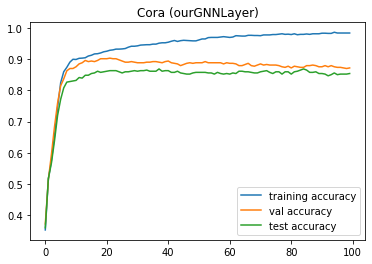

In [9]:
import matplotlib.pyplot as plt

# 开始训练
model, train_acc, val_acc, test_acc = train(train_loader, val_loader,test_loader,args, num_node_features, num_classes, args["device"])

# 打印模型
print(model)

# 可视化训练过程
plt.title(pyg_dataset.name + " ("+ args['model'] + ")")
plt.plot(train_acc, label="training accuracy")
plt.plot(val_acc, label="val accuracy")
plt.plot(test_acc, label="test accuracy")
plt.legend()
plt.show()
